# Local Spatial Autocorrelation

- Despite their importance, global measures of spatial autocorrelation are “whole map” statistics. They provide a single summary for an entire data set. For example, Moran’s I is a good tool to summarize a dataset into a single value that captures the degree of geographical clustering (or dispersion, if negative). However, Moran’s I does not indicate areas within the map where specific types of values (e.g. high, low) are clustered, or instances of explicit dispersion. In other words, Moran’s I can tell us whether values in our map cluster together (or disperse) overall, but it will not inform us about where specific clusters (or outliers) are.

* In this chapter, we introduce local measures of spatial autocorrelation. Local measures of spatial autocorrelation focus on the relationships between each observation and its surroundings, rather than providing a single summary of these relationships across the map. 

## An empirical illustration: the EU Referendum

In [7]:
import matplotlib.pyplot as plt 
from matplotlib import colors
import seaborn as sns  # Graphics
import geopandas as gpd  # Spatial data manipulation
import pandas as pd  
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/spaghetti/network.py:39: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
ref = pd.read_csv(
    "./geo_data/brexit/brexit_vote.csv", index_col="Area_Code"
)
ref

,id,Region_Code,Region,Area,Electorate,ExpectedBallots,VerifiedBallotPapers,Pct_Turnout,Votes_Cast,Valid_Votes,Remain,Leave,Rejected_Ballots,No_official_mark,Voting_for_both_answers,Writing_or_mark,Unmarked_or_void,Pct_Remain,Pct_Leave,Pct_Rejected
Area_Code,,,,,,,,,,,,,,,,,,,,
E06000031,108,E12000006,East,Peterborough,120892,87474,87469,72.35,87469,87392,34176,53216,77,0,32,7,38,39.11,60.89,0.09
E06000032,109,E12000006,East,Luton,127612,84633,84636,66.31,84616,84481,36708,47773,135,0,85,0,50,43.45,56.55,0.16
E06000033,112,E12000006,East,Southend-on-Sea,128856,93948,93939,72.90,93939,93870,39348,54522,69,0,21,0,48,41.92,58.08,0.07
E06000034,113,E12000006,East,Thurrock,109897,79969,79954,72.75,79950,79916,22151,57765,34,0,8,3,23,27.72,72.28,0.04
E06000055,110,E12000006,East,Bedford,119530,86136,86136,72.06,86135,86066,41497,44569,69,0,26,1,42,48.22,51.78,0.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E08000032,65,E12000003,Yorkshire and The Humber,Bradford,342817,228729,228729,66.72,228727,228488,104575,123913,239,0,121,5,113,45.77,54.23,0.10
E08000033,66,E12000003,Yorkshire and The Humber,Calderdale,149195,106005,106008,71.05,106004,105925,46950,58975,79,0,22,15,42,44.32,55.68,0.07
E08000034,67,E12000003,Yorkshire and The Humber,Kirklees,307081,217460,217449,70.80,217428,217240,98485,118755,188,0,86,7,95,45.33,54.67,0.09


In [3]:
lads = gpd.read_file(
    "./geo_data/brexit/local_authority_districts.geojson"
).set_index("lad16cd")
lads

,objectid,lad16nm,lad16nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,None,447157,531476,-1.27023,54.676159,0.013041,0.879421,"MULTIPOLYGON (((-1.27024 54.72716, -1.38088 54..."
E06000002,2,Middlesbrough,None,451141,516887,-1.21099,54.544670,0.007484,0.535764,"MULTIPOLYGON (((-1.23001 54.58410, -1.28158 54..."
E06000003,3,Redcar and Cleveland,None,464359,519597,-1.00611,54.567520,0.034014,1.266847,"MULTIPOLYGON (((-1.13716 54.64693, -1.13256 54..."
E06000004,4,Stockton-on-Tees,None,444937,518183,-1.30669,54.556911,0.028479,1.424195,"MULTIPOLYGON (((-1.31774 54.64524, -1.38088 54..."
E06000010,10,"Kingston upon Hull, City of",None,511894,431716,-0.30380,53.769791,0.009740,0.782168,"MULTIPOLYGON (((-0.31613 53.81325, -0.35366 53..."
...,...,...,...,...,...,...,...,...,...,...
W06000018,385,Caerphilly,Caerffili,317245,195259,-3.19753,51.650009,0.036040,1.302514,"POLYGON ((-3.30131 51.79897, -3.31009 51.79430..."
W06000019,386,Blaenau Gwent,Blaenau Gwent,318236,206771,-3.18592,51.753639,0.014163,0.760273,"POLYGON ((-3.24823 51.81515, -3.31009 51.79430..."
W06000021,388,Monmouthshire,Sir Fynwy,337812,209231,-2.90280,51.778271,0.110769,2.590144,"MULTIPOLYGON (((-3.05214 51.97294, -3.06736 51..."


In [5]:
# Trim the dataframe

db = (
    gpd.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int32   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int32(1), object(1)
memory usage: 21.5+ KB


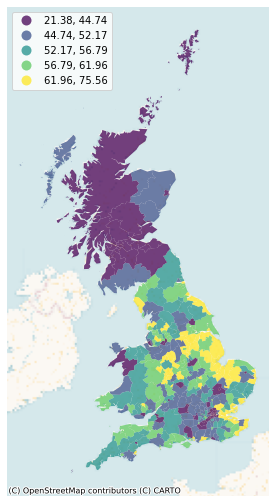

In [8]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [9]:
# Spatial weights matrix

# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

### Motivating Local Spatial Autocorrelation

In [ ]:
# Calculate the spatial lag structure

In [10]:
db["w_Pct_Leave"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)

In [11]:
# Standardize

db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["w_Pct_Leave_std"] = db["w_Pct_Leave"] - db["Pct_Leave"].mean()



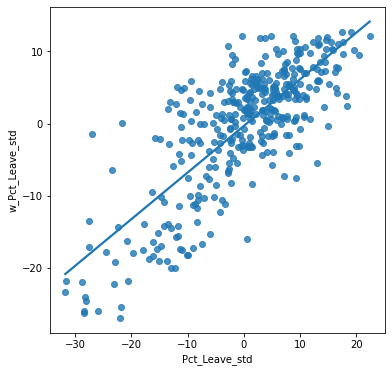

In [12]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
);

- Using standardized values, we can immediately divide each variable (the percentage that voted to leave, and its spatial lag) in two groups: those with above-average leave voting, which have positive standardized values; and those with below-average leave voting, which feature negative standardized values.

*  Applying this thinking to both the percentage to leave and its spatial lag, divides a Moran Plot in four quadrants. Each of them captures a situation based on whether a given area displays a value above the mean (high) or below (low) in either the original variable (Pct_Leave) or its spatial lag (w_Pct_Leave_std). Using this terminology, we name the four quadrants as follows: high-high (HH) for the top-right, low-high (LH) for the top-left, low-low (LL) for the bottom-left, and high-low (HL) for the bottom right. Graphically, we can capture this as follows:

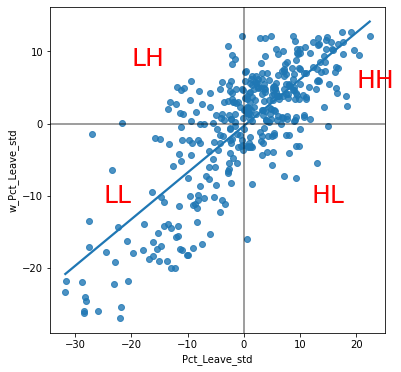

In [13]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
sns.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()


## Local Moran’s Ii, Lisa


- One way to look at the figure above is as a classification of each observation in the dataset depending on its value and that of its neighbors
- But remember local measures help us to identify areas of unusual concentration of values. Clusters will represent values of one type that are unlikely to appear under the assumption of spatial randomness. To know whether each location belongs to a statistically significant cluster of a given kind, we thus need to compare it with what we would expect if the data were allocated over space in a completely random way. However, what we are interested in is whether the strength with which the values are concentrated is unusually high.
- LISAs are widely used in many fields to identify geographical clusters of values or find geographical outliers.
- The core idea of a local Moran's $I_i$ is to identify cases in which the value of an observation and the average of its surroundings is either more similar (HH or LL in the scatterplot above) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation. This results in as many statistics as original observations. The formal representation of the statistic can be written as:

$$
I_i = \dfrac{z_i}{m_2} \displaystyle\sum_j w_{ij} z_j \; ; \; m_2 = \dfrac{\sum_i z_i^2}{n}
$$

where $m_2$ is the second moment (variance) of the distribution of values in the data, $z_i = y_i - \bar{y}$, $w_{i,j}$ is the spatial weight for the pair of observations $i$ and $j$, and $n$ is the number of observations.


In [ ]:
# Used for identify geographical clusters of poverty, map ethnic enclaves, clusters of contagious disease and etc.

- In Python, we can calculate LISAs in a very streamlined way thanks to esda. To compute local Moran statistics, we use the Moran_Local function:

In [14]:
lisa = esda.moran.Moran_Local(db["Pct_Leave"], w) #passing the proportionof Leave votes and spatial weights that
                                                 #describes neigh. relations between the different areas

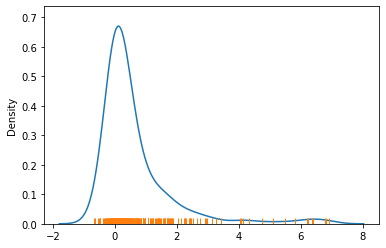

In [17]:
# Draw a KDE line
ax = sns.kdeplot(lisa.Is)  #in Is attribute, local indicators, plotting the distribution of it

# adding a small bar (rug) for each observation

sns.rugplot(lisa.Is, ax=ax);

In [ ]:
# Skewed ditribution of lolac Moran's I statistic
# Most of the local values are positive
# High values being next to high values or low next to low values
# The values left in tail represent negative spatial association
# High values being next to low, or low next to high
# We can't distinguish

In [18]:
from splot import esda as esdaplot

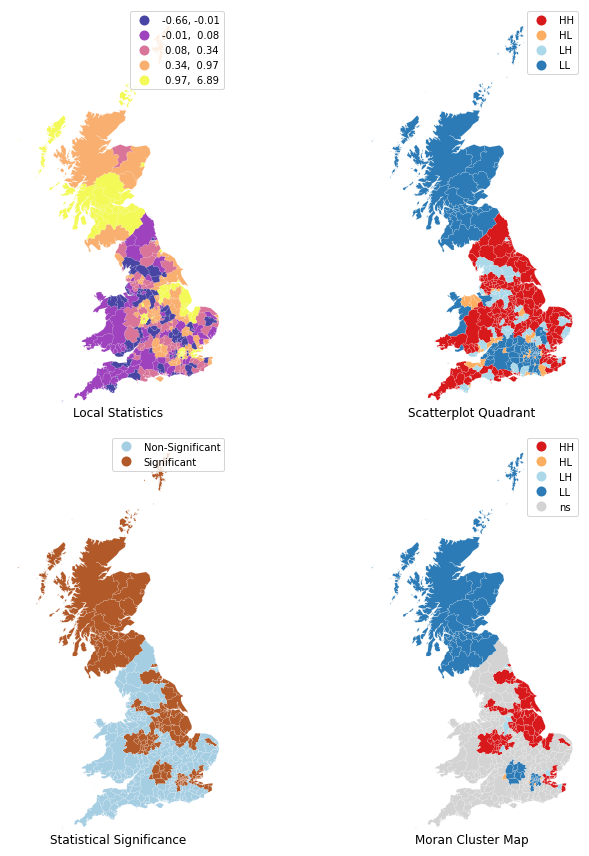

In [20]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

In [21]:
lisa.q[:20]

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2])

In [23]:
counts = pd.value_counts(lisa.q)
counts

1    183
3    113
2     50
4     34
dtype: int64

The correspondence between the numbers in the q attribute and the actual quadrants is as follows: 1 represents observations in the HH quadrant, 2 those in the LH one, 3 in the LL region, and 4 in the HL quadrant.

In [24]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

42.36842105263158

In [25]:
# A little over 41% of the local authorities are considered, by this analysis, to be part of a spatial cluster.

In [26]:
# we identify three clear areas of low support for leaving the EU: Scotland, London, and the area around Oxford (North-West of London). And third, although there appeared to be many areas with concentrated values indicating high support, it is only the region in the North-East and West of England whose spatial concentration shows enough strength to reasonably rule out pure chance.

In [27]:
# Pull out the information computed in lisa and insert it in main data table

In [28]:
# Assign pseudo P-values to `db`
db["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
db["sig"] = sig
# Print top of the table to inspect
db[["sig", "p-sim"]].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.012
E06000002,1,0.012
E06000003,1,0.014
E06000004,1,0.014
E06000010,1,0.018


In [30]:
# Print bottom of the table to inspect
db[["sig", "p-sim"]].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.012
E06000002,1,0.012
E06000003,1,0.014
E06000004,1,0.014
E06000010,1,0.018


In [ ]:
# first 5 values stat. significant

In [33]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
db["labels"] = pd.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=db.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
db.head()

,objectid,lad16nm,Pct_Leave,geometry,w_Pct_Leave,Pct_Leave_std,w_Pct_Leave_std,p-sim,sig,labels
lad16cd,,,,,,,,,,
E06000001,1,Hartlepool,69.57,"MULTIPOLYGON (((-141402.215 7309092.065, -1537...",60.92125,16.429237,7.780487,0.012,1,HH
E06000002,2,Middlesbrough,65.48,"MULTIPOLYGON (((-136924.099 7281563.141, -1426...",61.02625,12.339237,7.885487,0.012,1,HH
E06000003,3,Redcar and Cleveland,66.19,"MULTIPOLYGON (((-126588.382 7293641.928, -1260...",60.65125,13.049237,7.510487,0.014,1,HH
E06000004,4,Stockton-on-Tees,61.73,"MULTIPOLYGON (((-146690.634 7293316.144, -1537...",60.84375,8.589237,7.702987,0.014,1,HH
E06000010,10,"Kingston upon Hull, City of",67.62,"MULTIPOLYGON (((-35191.009 7134866.244, -39368...",60.46750,14.479237,7.326737,0.018,1,HH


In [34]:
db["labels"].value_counts()

Non-Significant    219
HH                  77
LL                  73
LH                   7
HL                   4
Name: labels, dtype: int64

In [35]:
# Most local statistics are not statistically significant.

## Getis and Ord’s local statistics

- The Gi statistic, which omits the value at a site in its local summary, and the Gi∗
    , which includes the site’s own value in the local summary.

In [36]:
# Gi
go_i = esda.getisord.G_Local(db["Pct_Leave"], w)
# Gi*
go_i_star = esda.getisord.G_Local(db["Pct_Leave"], w, star=True)

In [ ]:
# splot does not support visualisation of G statistic at this point. Write a function

In [39]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...
    Arguments
    --------
    g: G_Local
        Object from the computation of the G statistic
    db: GeoDataFrame
        Table aligned with values in 'g' and containing the geometries to plot
    ax: AxesSubplot
        'matplotlib' axis to draw the map on
        
    Returns
    -----------
    ax: Axes Subplot
        Axis with map drawn
        
    """
    # Break observations into significant or not
    sig = g.p_sim < 0.05
    
    #Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor='white', linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor='white', linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor='white', linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source=contextily.providers.Stamen.TerrainBackground,
    )
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for Pct of Leave votes", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax


    

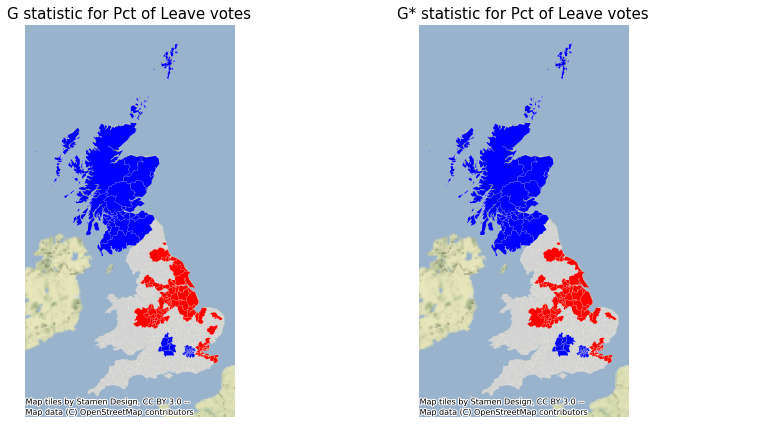

In [40]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, db, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()

In [41]:
# Same results for Gi and Gi*
#local I statistic (on its own) gives an indication of cluster/outlier status, and the local G
# shows which side of the hotspot/coldspot divide the observation is on. 

# Local statistics on surfaces

In [ ]:
# Compute local Moran's on a surface data

In [47]:
 #Open GeoTIFF file and read into `xarray.DataArray`
pop = xarray.open_rasterio("geo_data/ghsl_sao_paulo.tif")

In [ ]:
# Build a weight matrix that represents the spatial configuration of pixels with values in pop

In [48]:
w_surface_sp = weights.Queen.from_xarray(pop)

In [49]:
w_surface_sp.sparse.dtype

dtype('int8')

In [50]:
type(w_surface_sp)

libpysal.weights.weights.WSP